In [1]:
import numpy as np
import cyipopt
from cyipopt import minimize_ipopt
import jax
import jax.numpy as jnp
from typing import Dict

In [525]:
import jax.numpy as jnp

In [530]:
jnp.zeros((1,3)).shape

(1, 3)

In [396]:
from functools import partial
from copy import deepcopy

class NLP:
    def __init__(self, dim):
        self.dim = dim
        self.lb = [-np.inf]*dim
        self.ub = [np.inf]*dim
        self.cl = []
        self.cu = []
        self.obj_fn = None
        self.const_fns = []
    
    def set_bounds(self, lb, ub):
        assert len(lb) == len(ub) == self.dim
        self.lb = lb
        self.ub = ub

    def set_objective(self, fn):
        self.obj_fn = fn

    def set_const_fn(self, fn, eq_value=None, ineq_lb=None, ineq_ub=None):
        self.const_fns += [fn]
        lb, ub = -jnp.inf, jnp.inf
        if eq_value is not None:
            lb = ub = eq_value
        else: 
            if ineq_lb is not None:
                lb = ineq_lb
            if ineq_ub is not None:
                ub = ineq_ub
        self.cl += [lb]
        self.cu += [ub]
    
    def get_combined_constraint(self):
        const_fn = lambda x: jnp.hstack([fn(x) for fn in self.const_fns])
        cl = jnp.hstack(self.cl)
        cu = jnp.hstack(self.cu)
        return const_fn, cl, cu

    def get_prob(self, use_hess=True, debug=False, return_fns=False):
        def obj_fn_debug(x):
            self.x_history.append(np.array(x))
            return self.obj_fn(x)
        if debug:
            self.x_history = []
            obj_fn = obj_fn_debug
        else:
            obj_fn = self.obj_fn
            
        const_fn, cl, cu = self.get_combined_constraint()
        return self.make_ipopt_prob(
            self.dim,
            obj_fn=obj_fn,
            const_fn=const_fn,
            lb=self.lb,
            ub=self.ub,
            cl=cl, cu=cu,
            use_hess=use_hess,
            debug=debug,
            return_fns=return_fns
        )
    
    def make_ipopt_prob(self, dim, obj_fn, const_fn, lb, ub, cl, cu, use_hess, debug, return_fns=False):
        x0 = jnp.zeros(dim)
        const_dim = len(const_fn(x0))
        fn_dict = {}
        fn_dict['objective'] = obj_fn
        fn_dict['gradient'] = jax.grad(self.obj_fn)
        fn_dict['obj_hess'] = jax.jacrev(jax.jacfwd(self.obj_fn))
        fn_dict['constraints'] = const_fn
        fn_dict['jacobian'] = jax.jacrev(const_fn)
        fn_dict['const_hess'] = jax.jacrev(jax.jacrev(const_fn))
        
        if use_hess and not debug:
            def hessian(x, lagrange, obj_factor):
                H_obj = obj_factor * fn_dict['obj_hess'](x)
                H_const = jnp.einsum('i,ijk->jk', lagrange, fn_dict['const_hess'](x))
                H = (H_obj + H_const)[jnp.tril_indices(dim)]
                return H
            fn_dict['hessian'] = hessian
        
        class Problem:
            pass
        prob = Problem()
        setattr(prob, "n", len(x0))
        setattr(prob, "m", len(const_fn(x0)))
        if debug:
            setattr(prob, "objective", obj_fn)
        else:
            setattr(prob, "objective", jax.jit(obj_fn).lower(x0).compile())

        for fn_name, fn in fn_dict.items():
            if fn_name in ['constraints', 'gradient', 'jacobian']:
                setattr(prob, fn_name, jax.jit(fn).lower(x0).compile())
            if fn_name in ['hessian'] and use_hess:
                setattr(prob, fn_name, jax.jit(fn).lower(x0, jnp.zeros(const_dim), 1.).compile())
        if return_fns:
            return fn_dict
        return cyipopt.Problem(
            n=dim,
            m=len(cl),
            problem_obj=prob,
            lb=lb,ub=ub,cl=cl,cu=cu
        )
            

In [398]:
#test prob
nlp = NLP(4)
lb = [1.0, 1.0, 1.0, 1.0]
ub = [5.0, 5.0, 5.0, 5.0]
nlp.set_bounds(lb, ub)
nlp.set_objective(lambda x: x[0]*x[3]*jnp.sum(x[:3]) + x[2])
nlp.set_const_fn(lambda x: jnp.prod(x), ineq_lb=25.)
nlp.set_const_fn(lambda x: jnp.sum(x**2), eq_value=40.)

prob = nlp.get_prob(use_hess=True)
x0 = [1.0, 5.0, 5.0, 1.0]
prob.solve(x0)

This is Ipopt version 3.14.10, running with linear solver MUMPS 5.2.1.

Number of nonzeros in equality constraint Jacobian...:        4
Number of nonzeros in inequality constraint Jacobian.:        4
Number of nonzeros in Lagrangian Hessian.............:       10

Total number of variables............................:        4
                     variables with only lower bounds:        0
                variables with lower and upper bounds:        4
                     variables with only upper bounds:        0
Total number of equality constraints.................:        1
Total number of inequality constraints...............:        1
        inequality constraints with only lower bounds:        1
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  1.6109694e+01 1.12e+01 5.28e-01  -1.0 0.00e+00    -  0.00e+00 0.00e+00 

(array([0.99999999, 4.74299946, 3.82114996, 1.37940838]),
 {'x': array([0.99999999, 4.74299946, 3.82114996, 1.37940838]),
  'g': array([25.00000191, 40.        ]),
  'obj_val': 17.014019012451172,
  'mult_g': array([-0.55229365,  0.16146856]),
  'mult_x_L': array([1.08787164e+00, 6.69490759e-10, 8.88256060e-10, 6.60476582e-09]),
  'mult_x_U': array([6.26475881e-10, 9.75057526e-09, 2.12571860e-09, 6.92125428e-10]),
  'status': 1,
  'status_msg': b'Algorithm stopped at a point that was converged, not to "desired" tolerances, but to "acceptable" tolerances (see the acceptable-... options).'})

In [515]:
class MP(NLP):
    def __init__(self, robot_dim, num_steps):
        self.robot_dim = robot_dim
        self.num_steps = num_steps
        super().__init__(
            dim=robot_dim*num_steps)
        self.robot_ub = None
        self.robot_lb = None

    def set_robot_bounds(self, lb, ub):
        self.robot_lb = lb
        self.robot_ub = ub
        lbs = np.tile(lb, self.num_steps)
        ubs = np.tile(ub, self.num_steps)
        self.set_bounds(lbs, ubs)
    
    def set_obstacle(self, sdf, safe_dist=0.05):
        def penet_const(x):
            sd = jax.vmap(sdf)(x.reshape(-1, self.robot_dim))
            return - jnp.where(sd+safe_dist < 0, sd + safe_dist, jnp.zeros_like(sd)).sum()
        self.set_const_fn(penet_const, ineq_ub=-safe_dist)
    
    def set_min_dist_objective(self):
        V = np.zeros((self.num_steps+1, self.num_steps))
        V[:self.num_steps, :self.num_steps] += jnp.eye(self.num_steps)
        V[1:, :self.num_steps] -= np.eye(self.num_steps)
        V = np.kron(V, np.eye(self.robot_dim))
        self.set_objective(lambda x: (V@x)@(V@x))
    
    def set_init_const(self, q_init):
        self.set_const_fn(lambda x: x[:self.robot_dim], q_init)
    
    def set_goal_const(self, q_goal):
        self.set_const_fn(lambda x: x[-self.robot_dim:], q_goal)

In [516]:
def safe_norm_maximum(x, y, eps: float = 1e-12) -> jnp.ndarray:
    norm_input = jnp.maximum(x, y)
    norm = jnp.sum(norm_input * norm_input) 
    norm = jnp.where(norm < eps, 0.0, norm)
    return jnp.sqrt(norm)

def sdf_box(point, box_size=jnp.array([0.2, 0.2]), center=jnp.array([0.5, 0.5])):
    q = jnp.abs(point-center) - box_size
    term1 = safe_norm_maximum(q, 0)
    term2 = jnp.minimum(jnp.maximum(q[0], jnp.maximum(q[1], q[2])), 0)
    return term1 + term2

sdf = partial(sdf_box, box_size=jnp.array([0.2,0.2]), center=jnp.array([0.5, 0.6]))
sdf_batch = jax.vmap(sdf)

In [523]:
mp = MP(2, 7)

mp.set_robot_bounds(jnp.zeros(2)-0.01, jnp.ones(2)+0.01)
mp.set_min_dist_objective()
mp.set_init_const(jnp.zeros(2))
mp.set_goal_const(jnp.ones(2))
mp.set_obstacle(sdf, safe_dist=0.002)
prob = mp.get_prob(use_hess=True, debug=True)

In [524]:
prob.add_option('tol', 1e-3)
#prob.add_option('mu_strategy', 'adaptive')
x, info = prob.solve(jnp.zeros(14))

This is Ipopt version 3.14.10, running with linear solver MUMPS 5.2.1.

Number of nonzeros in equality constraint Jacobian...:       56
Number of nonzeros in inequality constraint Jacobian.:       14
Number of nonzeros in Lagrangian Hessian.............:        0

Total number of variables............................:       14
                     variables with only lower bounds:        0
                variables with lower and upper bounds:       14
                     variables with only upper bounds:        0
Total number of equality constraints.................:        4
Total number of inequality constraints...............:        1
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:        1

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  0.0000000e+00 1.00e+00 0.00e+00   0.0 0.00e+00    -  0.00e+00 0.00e+00 

In [511]:
i=-2

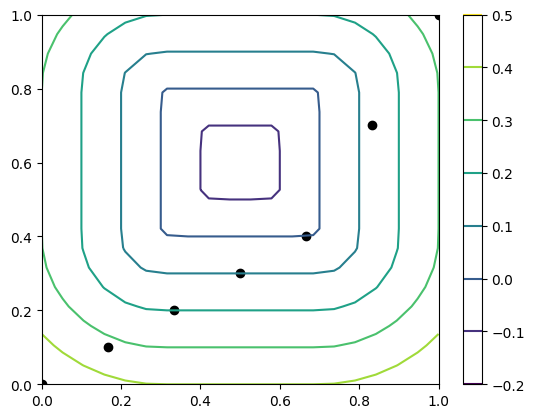

In [512]:
import matplotlib.pyplot as plt
i += 1
x = mp.x_history[i]
path = x.reshape(-1, mp.robot_dim)
plt.contour(X,Y,Z)
plt.colorbar()
plt.scatter(*path.T, color='k')


In [ ]:
class MP(NLP):
    def __init__(self, robot_dim, num_steps):
        self.robot_dim = robot_dim
        self.num_steps = num_steps
        super().__init__(dim = robot_dim*num_steps)
        self.joint_ub = None
        self.joint_lb = None
    
    def set_joint_limit(self, lb, ub):
        self.joint_lb = lb
        self.joint_ub = ub
        lbs = np.tile(lb, self.num_steps)
        ubs = np.tile(ub, self.num_steps)
        self.add_bounds(lbs, ubs)
    
    def set_min_dist_objective(self, q_init):
        # x = robot_dim * num_steps
        A = jnp.eye(self.dim)
        A -= jnp.block([[np.zeros((1, self.dim-1)),0],[np.eye(self.dim-1), np.zeros((self.dim-1,1))]])
        b = jnp.hstack([-q_init, np.zeros(self.robot_dim*(self.num_steps-1))])
        obj_fn = lambda x: 1/2 * (A@x+b)@(A@x+b)
        grad_fn = lambda x: (A@x+b)
        hess_fn = lambda x: A
        self.add_objective(obj_fn, grad_fn, hess_fn)
        fn = lambda x: x[:self.robot_dim]
        self.add_eq_const(fn, q_init)
    
    def set_vel_const(self, vlb, vub):
        vel_fn = lambda x: (x.reshape(self.num_steps,-1)[:-1] - x.reshape(self.num_steps,-1)[1:]).flatten()
        vlbs = np.tile(vlb, self.num_steps-1)
        vubs = np.tile(vub, self.num_steps-1)
        self.add_ineq_const(vel_fn, vlbs, "lb")
        self.add_ineq_const(vel_fn, vubs, "ub")

    def set_goal_joint(self, qgoal):
        fn = lambda x: x[-self.robot_dim:]
        self.add_eq_const(fn, qgoal)

In [ ]:
objective = lambda x: x[0]*x[3]*jnp.sum(x[:3]) + x[2]
constraints = lambda x: jnp.hstack([jnp.prod(x), jnp.sum(x**2)])


prob = nlp.make_ipopt_prob(objective, constraints)

In [ ]:
lb = [1.0, 1.0, 1.0, 1.0]
ub = [5.0, 5.0, 5.0, 5.0]
cl = [25.0, 40.0]
cu = [2.0e19, 40.0]

x0 = [1.0, 5.0, 5.0, 1.0]

nlp = cyipopt.Problem(
    n=prob.n,
    m=prob.m,
    problem_obj=prob,
    lb=lb,ub=ub,cl=cl,cu=cu
)

In [ ]:
x, info = nlp.solve(x0)

In [ ]:
class NLP:
    def __init__(self, dim):
        self.dim = dim
        self.obj_fn = None
        self.grad_fn = None
        self.hess_fn = None
        self.eq_const = []
        self.ineq_const = []
        self.lb = None
        self.ub = None

    def add_objective(self, fn, grad_fn=None, hess_fn=None):
        self.obj_fn = fn
        if grad_fn is not None:
            self.grad_fn = grad_fn
        if hess_fn is not None:
            self.hess_fn = hess_fn
    
    def add_bounds(self, lb=None, ub=None):
        self.lb = lb
        self.ub = ub

    def add_eq_const(self, fn, val):
        fn_ = lambda x: fn(x) - val
        self.eq_const.append(fn_)
    
    def add_ineq_const(self, fn, val, bound_type="lb"):
        if bound_type == "lb":
            fn_ = lambda x: fn(x) - val
        else:
            fn_ = lambda x: -fn(x) + val
        self.ineq_const.append(fn_)
    
    def get_prob_dict(self):
        prob = {}
        prob['fun'] = jax.jit(self.obj_fn)
        if self.grad_fn is not None:
            prob['jac'] = jax.jit(jax.grad(self.obj_fn))
        else:
            prob['jac'] = jax.jit(self.grad_fn)
        if self.hess_fn is not None:
            prob['hess'] = jax.jit(jax.jacrev(jax.jacfwd(self.obj_fn)))
        else:
            prob['hess'] = jax.jit(self.hess_fn)
        
        prob['constraints'] = []
        if len(self.eq_const) != 0:
            if len(self.eq_const) == 1:
                eq = self.eq_const[0]
            else: 
                eq = lambda x: jnp.hstack([fn(x) for fn in self.eq_const])
            eq = jax.jit(eq)
            eq_jac = jax.jit(jax.jacfwd(eq))
            eq_hess = jax.jacrev(jax.jacfwd(eq))
            eq_hessvp = jax.jit(lambda x, v: eq_hess(x) * v[0])
            prob['constraints'].append({'type':'eq', 'fun':eq, 'jac': eq_jac, 'hess': eq_hessvp})
        
        if len(self.ineq_const) != 0:
            if len(self.ineq_const) == 1:
                ineq = self.ineq_const[0]
            else:
                ineq = lambda x: jnp.hstack([fn(x) for fn in self.ineq_const])
            ineq = jax.jit(ineq)
            ineq_jac = jax.jit(jax.jacfwd(ineq))
            ineq_hess = jax.jacrev(jax.jacfwd(ineq))
            ineq_hessvp = jax.jit(lambda x, v: ineq_hess(x) * v[0])
            prob['constraints'].append({'type':'ineq', 'fun':ineq, 'jac': ineq_jac, 'hess': ineq_hessvp})
        prob['bounds'] = [(l, u) for l, u in zip(self.lb, self.ub)]
        self.prob = prob
        
    def solve(self, x0, tol=0.001, max_iter=100):
        options = {"max_iter":max_iter}
        return minimize_ipopt(x0=x0, tol=tol, options=options, **self.prob)

In [ ]:
class MP(NLP):
    def __init__(self, robot_dim, num_steps):
        self.robot_dim = robot_dim
        self.num_steps = num_steps
        super().__init__(dim = robot_dim*num_steps)
        self.joint_ub = None
        self.joint_lb = None
    
    def set_joint_limit(self, lb, ub):
        self.joint_lb = lb
        self.joint_ub = ub
        lbs = np.tile(lb, self.num_steps)
        ubs = np.tile(ub, self.num_steps)
        self.add_bounds(lbs, ubs)
    
    def set_min_dist_objective(self, q_init):
        # x = robot_dim * num_steps
        A = jnp.eye(self.dim)
        A -= jnp.block([[np.zeros((1, self.dim-1)),0],[np.eye(self.dim-1), np.zeros((self.dim-1,1))]])
        b = jnp.hstack([-q_init, np.zeros(self.robot_dim*(self.num_steps-1))])
        obj_fn = lambda x: 1/2 * (A@x+b)@(A@x+b)
        grad_fn = lambda x: (A@x+b)
        hess_fn = lambda x: A
        self.add_objective(obj_fn, grad_fn, hess_fn)
        fn = lambda x: x[:self.robot_dim]
        self.add_eq_const(fn, q_init)
    
    def set_vel_const(self, vlb, vub):
        vel_fn = lambda x: (x.reshape(self.num_steps,-1)[:-1] - x.reshape(self.num_steps,-1)[1:]).flatten()
        vlbs = np.tile(vlb, self.num_steps-1)
        vubs = np.tile(vub, self.num_steps-1)
        self.add_ineq_const(vel_fn, vlbs, "lb")
        self.add_ineq_const(vel_fn, vubs, "ub")

    def set_goal_joint(self, qgoal):
        fn = lambda x: x[-self.robot_dim:]
        self.add_eq_const(fn, qgoal)

In [ ]:
robot_dim = 2
num_steps = 10

q0 = jnp.zeros(robot_dim)

In [ ]:
mp = MP(robot_dim, num_steps)

mp.set_min_dist_objective(q0)
mp.set_joint_limit(-jnp.ones(2)*1.02, jnp.ones(2)*1.02)
# mp.set_vel_const(jnp.array([-0.1, -0.1]), jnp.array([0.1, 0.1]))
mp.set_goal_joint(jnp.ones(2))
mp.get_prob_dict()

In [ ]:
res = mp.solve(jnp.zeros(20)*0.01, tol=0.00001, max_iter=100)

In [ ]:
robot_dim = 2
num_steps = 10
dim = robot_dim*num_steps
q0 = jnp.zeros(robot_dim) #np.random.random(robot_dim)
x0 = jnp.tile(q0, num_steps)

In [ ]:
def constraints(x):
    q0 = x[:robot_dim]
    qf = x[-robot_dim:]
    return jnp.hstack([q0, qf])

In [ ]:
from functools import partial
x = jnp.arange(20.)
get_init_state_fn = partial(state_window_fn, 0)
get_goal_state_fn = partial(state_window_fn, -1)

In [ ]:
from functools import partial
from functools import partial
from jax import lax

state_window_fn: jax.jit(lambda x, start_idx, end_idx: x[start_idx:end_idx])

class MP:
    def __init__(self, robot_dim, num_steps, q_init, q_goal):
        self.robot_dim = robot_dim
        self.num_steps = num_steps
        self.dim = dim
        self.q_init = q_init
        self.q_goal = q_goal
        self.const = []
        self.cl = []
        self.cu = []
        
    
    def add_start_constraint(self, q):
        assert len(q) == self.robot_dim
        self.const += [lambda x: x[:self.robot_dim]]
        self.cl += [q]
        self.cu += [q]
    
    def add_goal_constraint(self, q):
        assert len(q) == self.robot_dim
        self.const += [lambda x: x[-self.robot_dim:]]
        self.cl += [q]
        self.cu += [q]
    
    def get_min_travelled_cost_fn(x):
        return jax.jit(lambda x: 1/2*(V@x)@(V@x))
    
    def get_const_fn(self):
        return jax.jit(lambda x: jnp.hstack([fn(x) for fn in self.const]))
    
    def get_const_bound(self):
        return jnp.hstack(self.cl), jnp.hstack(self.cu)
    
    def make_prob(self, fns):
        class Prob:
            pass
        prob = Prob()
        functions = ['objective', 'gradient', 'hessian', 'constraints', 'jacobian']
        for fn_name, fn in fns.items():
            if fn_name in functions:
                setattr(prob, fn_name, fn)
        return prob

In [ ]:
q_init = jnp.array([0.5,0])
q_goal = jnp.array([1,1])
mp = MP(robot_dim=2, num_steps=5, q_init=q_init, q_goal=q_goal)

In [ ]:
mp.add_start_constraint(q_init)
mp.add_goal_constraint(q_goal)

In [ ]:
obj = mp.get_min_travelled_cost_fn()
grad = jax.jit(jax.grad(obj))
hess = jax.jit(jax.jacrev(jax.jacfwd(obj)))
const_fn = mp.get_const_fn()
const_jac_fn = jax.jit(jax.jacfwd(const_fn))

fns = dict(
    objective=min_travelled_cost,
    gradient=min_travelled_grad,
    hessian=min_travelled_hess,
    constraints=const_fn,
    jacobian=const_jac_fn
)
prob = 

In [ ]:
def hessian(self, x, lagrange, obj_factor):
    H = obj_factor * self.obj_hess(x)  # type: ignore
    # split the lagrangian multipliers for each constraint hessian
    lagrs = np.split(lagrange, np.cumsum(self._constraint_dims[:-1]))
    for hessian, args, lagr in zip(self._constraint_hessians, self._constraint_args, lagrs):
        H += hessian(x, lagr, *args)
    return H[np.tril_indices(x.size)]

In [ ]:
prob = cyipopt.Problem(
    n=mp.dim,
    m=len(mp.const),
    problem_obj=mp.make_prob(fns),
    lb=jnp.zeros(mp.dim),
    ub=jnp.ones(mp.dim),
    cl=mp.cl,
    cu=mp.cu
)

In [ ]:
prob.solve(jnp.zeros(20))

In [ ]:
num_steps = 10
V = np.zeros((num_steps+1, num_steps))
V[:num_steps, :num_steps] += np.eye(num_steps)
V[1:, :num_steps] -= np.eye(num_steps)
V = np.kron(V, np.eye(robot_dim))
#Vb = jnp.hstack([-q_init, jnp.zeros(robot_dim*(num_steps))])

In [ ]:
dim = robot_dim * num_steps
lb = -jnp.ones(dim)
ub = 2*jnp.ones(dim)
cl = jnp.hstack([q_init, q_goal])
cu = jnp.hstack([q_init, q_goal])
#q_init = jnp.array([0.5,0])

obj = lambda x: (V@x)@(V@x) #(V@x+Vb)@(V@x+Vb) #(A@x+Ab)@(A@x+Ab) + 
grad = jax.grad(obj)
def constraints(x):
    q0 = x[:robot_dim]
    qf = x[-robot_dim:]
    return jnp.hstack([q0, qf])
jac = jax.jacfwd(constraints)
fns = dict(obj=obj, grad=grad, const=constraints, jac=jac)
mp = MP(robot_dim, num_steps, q_init, q_goal, fns)

In [ ]:
prob = cyipopt.Problem(
    n=20,
    m=4,
    problem_obj=mp,
    lb=lb,
    ub=ub,
    cl=cl,
    cu=cu
)

In [ ]:
xsol = jnp.repeat(jnp.linspace(0, 1, 10),2)
mp.objective(xsol)

In [ ]:
prob.add_option('max_iter', 100)
prob.add_option('tol', 0.001)
x, info = prob.solve(jnp.zeros(20))

In [ ]:
import matplotlib.pyplot as plt
path = x.reshape(num_steps, robot_dim)
plt.scatter(*path.T)

In [ ]:
path = x.reshape(num_steps, robot_dim)
plt.scatter(*path.T)

In [ ]:
ineq1 = lambda x: np.prod(x) - 25
ineq2 = lambda x: np.prod(x) - 25
ineq3 = lambda x: x - 25
ineqs = [ineq1, ineq2, ineq3]
ineq = lambda x: jnp.hstack([fn(x) for fn in ineqs])

In [ ]:
jax.jacfwd(ineq)(jnp.zeros(5))

In [ ]:
nlp = NLP(4)
nlp.add_objective(lambda x: x[0]*x[3]*np.sum(x[:3]) + x[2])
nlp.add_eq_const(lambda x: np.sum(x**2) - 40)
nlp.add_ineq_const(lambda x: np.prod(x) - 25)
nlp.add_bounds(jnp.ones(4), jnp.full(4, 5))
nlp.get_prob_dict()

In [ ]:
%timeit ans = nlp.solve(jnp.array([1,5,5,1.]))